In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle, os, sys
import matplotlib as mpl
from scipy.interpolate import SmoothBivariateSpline
from matplotlib.colors import LogNorm, Normalize

In [2]:
from get_weight_isoscalar_constant_Emin_50GeV_Q2min1GeV import *

In [3]:
# from get_weight_isoscalar_constant_Emin_50GeV import *
pth_spl = '../diff_xsec/splines_flat/'
wf_nucc = pickle.load(open(pth_spl+'NuMu_CC_flat.pckl','rb'), encoding='latin1') 
wf_nubarcc = pickle.load(open(pth_spl+'NuMu_Bar_CC_flat.pckl','rb'), encoding='latin1') 
wf_nunc = pickle.load(open(pth_spl+'NuMu_NC_flat.pckl','rb'), encoding='latin1') 
wf_nubarnc = pickle.load(open(pth_spl+'NuMu_Bar_NC_flat.pckl','rb'), encoding='latin1') 

#coef = 0. -- Genie -> Genie
#coef = 1. -- Genie -> Nugen
def get_weight(E, y, xs_type, coef=1., lgE_min=2.): 
    
    lgE = np.log10(E)
    
    spl_lgE_reg = np.transpose(np.argwhere(lgE > lgE_min))[0]
    ext_lgE_reg = np.transpose(np.argwhere(lgE <= lgE_min))[0]
    
    w0 = np.ones(len(lgE))
    
    if xs_type == 'NuCC':
        weight_func = wf_nucc
    elif xs_type == 'NuBarCC':
        weight_func = wf_nubarcc
    elif xs_type == 'NuNC':
        weight_func = wf_nunc
    elif xs_type == 'NuBarNC':
        weight_func = wf_nubarnc
    else:
        print ('specify xs_type correctly!')
    
    w0[spl_lgE_reg] = weight_func.ev(lgE[spl_lgE_reg],y[spl_lgE_reg])
    w0[ext_lgE_reg] = weight_func.ev(w0[ext_lgE_reg]*lgE_min,y[ext_lgE_reg])
    w = w0*(1. + (1./w0 - 1)*(1. - coef))
    
    return w0

In [4]:
indir = '/home/mliubar/projects/rpp-kenclark/hignight/atmo_flux'
numu = pickle.load(open(os.path.join(indir, 'Level5p_IC86.2013_genie_numu.14600.rlogL.pckl'),'rb'),encoding='latin1')
nue = pickle.load(open(os.path.join(indir, 'Level5p_IC86.2013_genie_nue.12600.rlogL.pckl'),'rb'),encoding='latin1')

In [5]:
plt.rcParams.update({'font.size': 20})
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
mpl.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
mpl.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'

mpl.rcParams['patch.linewidth'] = 2.5
mpl.rcParams['lines.linewidth'] = 2.5

In [6]:
asp_r = 1./12.*6.

left, width = 0.23, 0.85
bottom, height = 0.16, 0.75
bottom_h = bottom + height + 0.02
left_h = left + width + 0.02

rect1 = [left*asp_r, bottom-0.2, width, height]
rect2 = [left*asp_r, bottom, height, 0.2]

# xsec type separation

In [7]:
nu = {}
for k in numu.keys():
    if k == 'weight_e': continue
    if k == 'weight_mu': 
        nu['weight_emu'] = np.concatenate((nue['weight_e'],numu['weight_mu']))
        continue
    nu[k] = np.concatenate((nue[k],numu[k]))

In [8]:
def myargwh(cond):
    return np.transpose(np.argwhere(cond))[0]

In [9]:
# dis = (np.abs(numu['ma_res']).sum(axis=1) == 0)*(np.abs(numu['ma_qe']).sum(axis=1) == 0)
ind0 = myargwh(np.abs(nu['ma_res']).sum(axis=1) == 0)
ind1 = myargwh(np.abs(nu['ma_qe'][ind0]).sum(axis=1) == 0)
# indQ2 = myargwh(nu['GENIE_Q2s'][ind0[ind1]] > 0.8)
dis = ind0[ind1]#[indQ2]]

In [10]:
CCdis = dis[myargwh(nu['interaction'][dis]==1.)]
NCdis = dis[myargwh(nu['interaction'][dis]==2.)]
CCnotdis = ~dis[myargwh(nu['interaction'][~dis]==1.)]
NCnotdis = ~dis[myargwh(nu['interaction'][~dis]==2.)]

In [11]:
CCdisNu = CCdis[myargwh(nu['ptype'][CCdis]>0)]
NCdisNu = NCdis[myargwh(nu['ptype'][NCdis]>0)]
CCnotdisNu = CCnotdis[myargwh(nu['ptype'][CCnotdis]>0)]
NCnotdisNu = NCnotdis[myargwh(nu['ptype'][NCnotdis]>0)]

CCdisNuBar = CCdis[myargwh(nu['ptype'][CCdis]<0)]
NCdisNuBar = NCdis[myargwh(nu['ptype'][NCdis]<0)]
CCnotdisNuBar = CCnotdis[myargwh(nu['ptype'][CCnotdis]<0)]
NCnotdisNuBar = NCnotdis[myargwh(nu['ptype'][NCnotdis]<0)]

In [12]:
val = np.log10(nu['energy'])
glob_w = nu['weight_emu']

In [13]:
# total + differential
def get_w_sum(weight=glob_w, nyears=1, 
          corr={'CCnu':False, 'CCnubar':False, 'NCnu':False, 'NCnubar':False}):
    
    if nyears == 0:
        m = 1.
    else:
        m = m = 365*24*60.*60.*nyears
        
    total_xsec_extr = 'constant'
    total_xsec_lgE_min = 2.
        
    wf = np.ones(len(glob_w))
    if corr['CCnu']:
        wf[CCdisNu] = wf[CCdisNu]*get_weight(nu['energy'][CCdisNu], 
                                             nu['GENIE_y'][CCdisNu], 
                                             xs_type='NuCC', 
                                             coef=1.)\
        *get_weight_iso(nu['energy'][CCdisNu], 
                        nu='Nu', current='CC', 
                        ext_type=total_xsec_extr,
                        lgE_min_cust=total_xsec_lgE_min)
    if corr['CCnubar']:
        wf[CCdisNuBar] = wf[CCdisNuBar]*get_weight(nu['energy'][CCdisNuBar], 
                                             nu['GENIE_y'][CCdisNuBar], 
                                             xs_type='NuBarCC', 
                                             coef=1.)\
        *get_weight_iso(nu['energy'][CCdisNuBar], 
                        nu='NuBar', current='CC', 
                        ext_type=total_xsec_extr,
                        lgE_min_cust=total_xsec_lgE_min)
    if corr['NCnu']:
        wf[NCdisNu] = wf[NCdisNu]*get_weight(nu['energy'][NCdisNu], 
                                             nu['GENIE_y'][NCdisNu], 
                                             xs_type='NuNC', 
                                             coef=1.)\
        *get_weight_iso(nu['energy'][NCdisNu], 
                        nu='Nu', current='NC', 
                        ext_type=total_xsec_extr,
                        lgE_min_cust=total_xsec_lgE_min)
    if corr['NCnubar']:
        wf[NCdisNuBar] = wf[NCdisNuBar]*get_weight(nu['energy'][NCdisNuBar], 
                                             nu['GENIE_y'][NCdisNuBar], 
                                             xs_type='NuBarNC', 
                                             coef=1.)\
       *get_weight_iso(nu['energy'][NCdisNuBar], 
                       nu='NuBar', current='NC', 
                       ext_type=total_xsec_extr,
                       lgE_min_cust=total_xsec_lgE_min)

    wr = weight*m*wf
    return wr, m

In [14]:
# differential
def get_w_diff(weight=glob_w, nyears=1, 
          corr={'CCnu':False, 'CCnubar':False, 'NCnu':False, 'NCnubar':False}):
    
    if nyears == 0:
        m = 1.
    else:
        m = m = 365*24*60.*60.*nyears
        
    total_xsec_extr = 'constant'
    total_xsec_lgE_min = 2.
        
    wf = np.ones(len(glob_w))
    if corr['CCnu']:
        wf[CCdisNu] = wf[CCdisNu]*get_weight(nu['energy'][CCdisNu], 
                                             nu['GENIE_y'][CCdisNu], 
                                             xs_type='NuCC', 
                                             coef=1.)
    if corr['CCnubar']:
        wf[CCdisNuBar] = wf[CCdisNuBar]*get_weight(nu['energy'][CCdisNuBar], 
                                             nu['GENIE_y'][CCdisNuBar], 
                                             xs_type='NuBarCC', 
                                             coef=1.)
    if corr['NCnu']:
        wf[NCdisNu] = wf[NCdisNu]*get_weight(nu['energy'][NCdisNu], 
                                             nu['GENIE_y'][NCdisNu], 
                                             xs_type='NuNC', 
                                             coef=1.)
    if corr['NCnubar']:
        wf[NCdisNuBar] = wf[NCdisNuBar]*get_weight(nu['energy'][NCdisNuBar], 
                                             nu['GENIE_y'][NCdisNuBar], 
                                             xs_type='NuBarNC', 
                                             coef=1.)

    wr = weight*m*wf
    return wr, m

In [15]:
# total
def get_w_tot(weight=glob_w, nyears=1, 
          corr={'CCnu':False, 'CCnubar':False, 'NCnu':False, 'NCnubar':False}):
    
    if nyears == 0:
        m = 1.
    else:
        m = m = 365*24*60.*60.*nyears
        
    total_xsec_extr = 'constant'
    total_xsec_lgE_min = 2.
        
    wf = np.ones(len(glob_w))
    if corr['CCnu']:
        wf[CCdisNu] = wf[CCdisNu]*get_weight_iso(nu['energy'][CCdisNu], 
                        nu='Nu', current='CC', 
                        ext_type=total_xsec_extr,
                        lgE_min_cust=total_xsec_lgE_min)
    if corr['CCnubar']:
        wf[CCdisNuBar] = wf[CCdisNuBar]*get_weight_iso(nu['energy'][CCdisNuBar], 
                        nu='NuBar', current='CC', 
                        ext_type=total_xsec_extr,
                        lgE_min_cust=total_xsec_lgE_min)
    if corr['NCnu']:
        wf[NCdisNu] = wf[NCdisNu]*get_weight_iso(nu['energy'][NCdisNu], 
                        nu='Nu', current='NC', 
                        ext_type=total_xsec_extr,
                        lgE_min_cust=total_xsec_lgE_min)
    if corr['NCnubar']:
        wf[NCdisNuBar] = wf[NCdisNuBar]*get_weight_iso(nu['energy'][NCdisNuBar], 
                       nu='NuBar', current='NC', 
                       ext_type=total_xsec_extr,
                       lgE_min_cust=total_xsec_lgE_min)

    wr = weight*m*wf
    return wr, m

# plots

In [16]:
save_pth = '/home/mliubar/scratch/jupyter_notebooks/total_and_diff/spline_plots_dec16/'

In [17]:
lgE_r = [0., 3.]
nb = 20

In [18]:
asp_r = 1./12.*6.

left, width = 0.33, 0.8
bottom, height = 0.12, 0.7
bottom_h = bottom + height + 0.02
left_h = left + width + 0.02

rect1 = [left*asp_r, bottom+0.3, width, height-0.2]
rect2 = [left*asp_r, bottom, width, 0.28]

In [19]:
lgE = np.linspace(0.,4., 100)
E = 10**lgE

In [20]:
y = np.linspace(0.,1.,100)

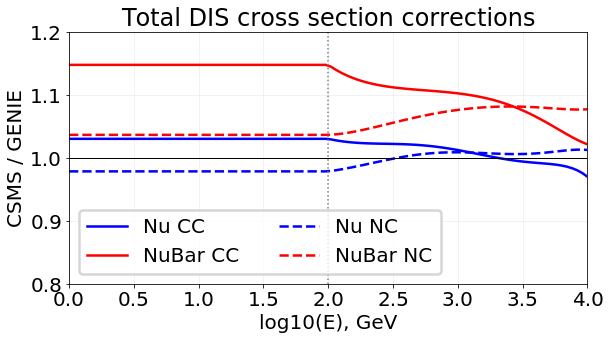

In [83]:
fig = plt.figure(1, figsize=(9, 7))
ax = plt.axes(rect1)



ax.set_xlim(0.,4.)
ax.set_ylim(0.8, 1.2)
ax.set_title('Total DIS cross section corrections')
ax.set_ylabel('CSMS / GENIE')
ax.set_xlabel('log10(E), GeV')

plt.plot(lgE, get_weight_iso(E, nu='Nu', current='CC', ext_type='constant', lgE_min_cust=2., coef=1.),
         color='blue', linestyle='-',
         label='Nu CC')
plt.plot(lgE, get_weight_iso(E, nu='NuBar', current='CC', ext_type='constant', lgE_min_cust=2., coef=1.),
         color='red', linestyle='-',
         label='NuBar CC')

plt.plot(lgE, get_weight_iso(E, nu='Nu', current='NC', ext_type='constant', lgE_min_cust=2., coef=1.),
         color='blue', linestyle='--',
         label='Nu NC')
plt.plot(lgE, get_weight_iso(E, nu='NuBar', current='NC', ext_type='constant', lgE_min_cust=2., coef=1.),
         color='red', linestyle='--',
         label='NuBar NC')

plt.axhline(1., linestyle='-', color='k', lw=1.)
plt.axvline(2., linestyle=':', color='gray', lw=1.5)
plt.grid(alpha=0.2)
plt.legend(ncol=2)

plt.savefig(save_pth+'tot_xsec_corr.png', dpi='figure')
plt.savefig(save_pth+'tot_xsec_corr.pdf', dpi='figure')

plt.show()

In [21]:
lgEv, yv = np.meshgrid(lgE, y)

In [22]:
lgEvf = lgEv.flatten()
Evf = 10**lgEvf
yvf = yv.flatten()

/home/mliubar/myjupyter_py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/mliubar/myjupyter_py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


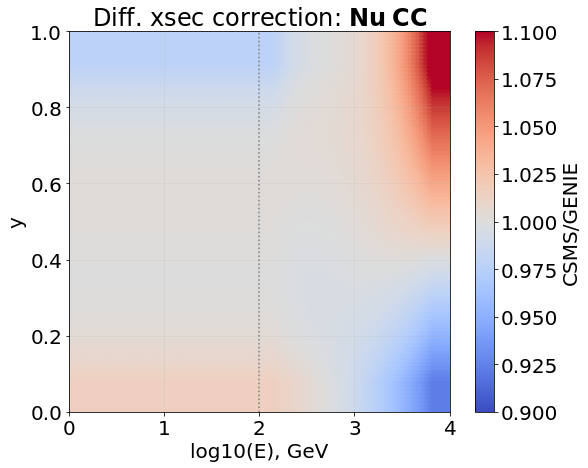

In [23]:
fig = plt.figure(1, figsize=(9, 7))
ax = plt.gca()


ax.set_aspect(4.)
ax.set_xlim(0.,4.)
ax.set_ylim(0., 1.)
ax.set_title(r'Diff. xsec correction: $\mathrm{\bf{Nu\:CC}}$')
ax.set_ylabel('y')
ax.set_xlabel('log10(E), GeV')

p=plt.scatter(lgEvf, yvf, c=get_weight(Evf, yvf, xs_type='NuCC', coef=1.),
            cmap='coolwarm', norm=Normalize(vmin=0.9,vmax=1.1),
         label='Nu CC')

plt.axvline(2., linestyle=':', color='gray', lw=1.5)
plt.grid(alpha=0.2)
fig.colorbar(p, label='CSMS/GENIE')
# plt.legend(ncol=2)

plt.savefig(save_pth+'diff_xsec_corr_NuCC.png', dpi='figure')
plt.savefig(save_pth+'diff_xsec_corr_NuCC.pdf', dpi='figure')

plt.show()

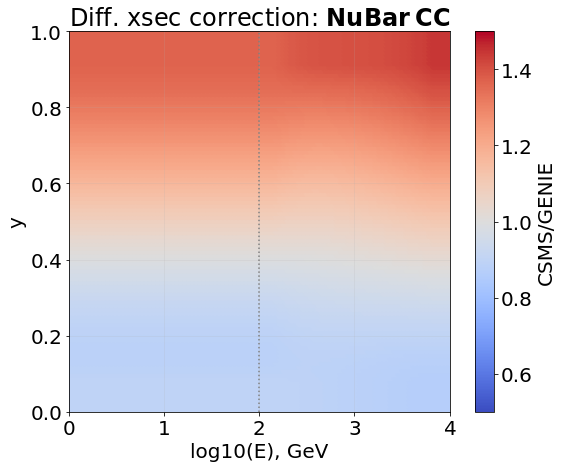

In [24]:
fig = plt.figure(1, figsize=(9, 7))
ax = plt.gca()


ax.set_aspect(4.)
ax.set_xlim(0.,4.)
ax.set_ylim(0., 1.)
ax.set_title(r'Diff. xsec correction: $\mathrm{\bf{NuBar\:CC}}$')
ax.set_ylabel('y')
ax.set_xlabel('log10(E), GeV')

p=plt.scatter(lgEvf, yvf, c=get_weight(Evf, yvf, xs_type='NuBarCC', coef=1.),
            cmap='coolwarm', norm=Normalize(vmin=0.5,vmax=1.5),
         label='Nu CC')

plt.axvline(2., linestyle=':', color='gray', lw=1.5)
plt.grid(alpha=0.2)
fig.colorbar(p, label='CSMS/GENIE')
# plt.legend(ncol=2)

plt.savefig(save_pth+'diff_xsec_corr_NuBarCC.png', dpi='figure')
plt.savefig(save_pth+'diff_xsec_corr_NuBarCC.pdf', dpi='figure')

plt.show()

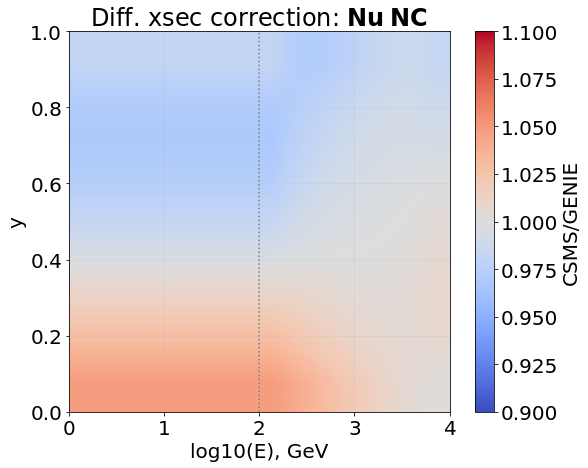

In [25]:
fig = plt.figure(1, figsize=(9, 7))
ax = plt.gca()


ax.set_aspect(4.)
ax.set_xlim(0.,4.)
ax.set_ylim(0., 1.)
ax.set_title(r'Diff. xsec correction: $\mathrm{\bf{Nu\:NC}}$')
ax.set_ylabel('y')
ax.set_xlabel('log10(E), GeV')

p=plt.scatter(lgEvf, yvf, c=get_weight(Evf, yvf, xs_type='NuNC', coef=1.),
            cmap='coolwarm', norm=Normalize(vmin=0.9,vmax=1.1),
         label='Nu CC')

plt.axvline(2., linestyle=':', color='gray', lw=1.5)
plt.grid(alpha=0.2)
fig.colorbar(p, label='CSMS/GENIE')
# plt.legend(ncol=2)

plt.savefig(save_pth+'diff_xsec_corr_NuNC.png', dpi='figure')
plt.savefig(save_pth+'diff_xsec_corr_NuNC.pdf', dpi='figure')

plt.show()

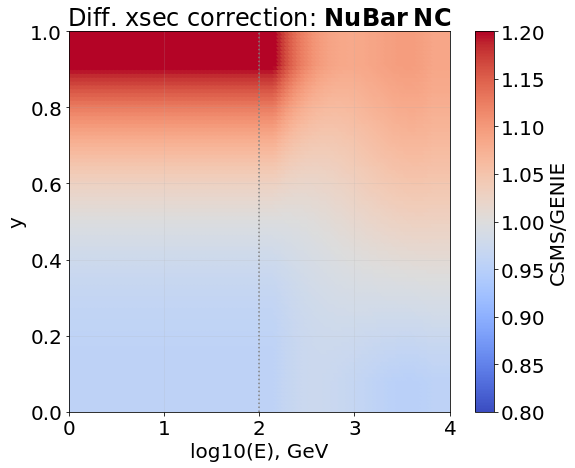

In [26]:
fig = plt.figure(1, figsize=(9, 7))
ax = plt.gca()


ax.set_aspect(4.)
ax.set_xlim(0.,4.)
ax.set_ylim(0., 1.)
ax.set_title(r'Diff. xsec correction: $\mathrm{\bf{NuBar\:NC}}$')
ax.set_ylabel('y')
ax.set_xlabel('log10(E), GeV')

p=plt.scatter(lgEvf, yvf, c=get_weight(Evf, yvf, xs_type='NuBarNC', coef=1.),
            cmap='coolwarm', norm=Normalize(vmin=0.8,vmax=1.2),
         label='Nu NC')

plt.axvline(2., linestyle=':', color='gray', lw=1.5)
plt.grid(alpha=0.2)
fig.colorbar(p, label='CSMS/GENIE')
# plt.legend(ncol=2)

plt.savefig(save_pth+'diff_xsec_corr_NuBarNC.png', dpi='figure')
plt.savefig(save_pth+'diff_xsec_corr_NuBarNC.pdf', dpi='figure')

plt.show()